# Diffusion refinement

In [1]:
import torch
import torchvision.transforms as TF
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

from config import cfg
from trainer import Trainer
from model import UNetCustResMul3AttenAdj2
from utils import model_init, load_model_vqvae

## Load sample sketch with corresponding segmentation mask

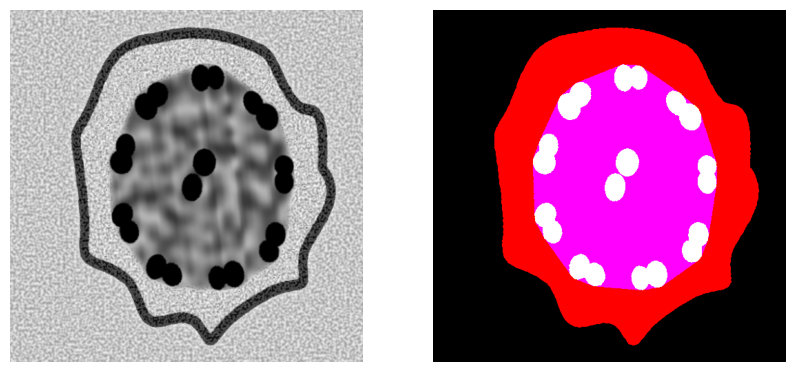

In [2]:
sketch_file = "../../samples/sample1.png"
mask_file = "../../samples/sample1_mask.png"

sketch = cv2.imread(sketch_file, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_file)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sketch, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')

plt.show()


## Setup model

In [3]:
model_pathname_vae = "./models/vqvae_autoencoder_ckpt_v2_512_adj2_random.pth"
model_pathname = './models/Ldm_adj2_cos_1000_v2adj2_512_2500.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

# Load trained model
model = UNetCustResMul3AttenAdj2(image_channels=cfg.latent_channels)
loaded_model = model_init(model_pathname, model)
loaded_model.to(device)

# Load vae model
model_vae = load_model_vqvae(model_pathname_vae, cfg.codebook_size)
model_vae.to(device)

trainer = Trainer(cfg, loaded_model)

input_transform = TF.Compose([
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda lam: (lam * 2) - 1)
])

device: cuda
Model loading successful!!

Device:  cuda


## Simple 1 stage approach
Simple 1 stage approach inspired by SDEdit

Sampling loop time step: 100%|█████████▉| 249/250 [00:01<00:00, 155.40it/s]


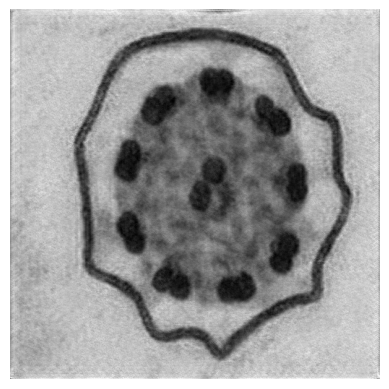

In [4]:
timestep = 250

sketch = Image.open(sketch_file)
sample_batch = input_transform(sketch)[None, :, :, :].to(device).float()

output = trainer.sample_image(loaded_model, model_vae, sample_batch, start_timestep=timestep)

image = np.clip(output.detach().cpu().numpy(), 0, 1) * 255
output_image = image[0][0].astype(np.uint8)

plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.show()

## Mask-guided diffusion refinement

Proposed 3 stage approach

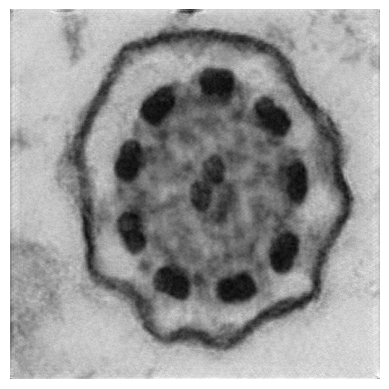

In [5]:
timestep_1 = 650
timestep_2 = 350
timestep_3 = 250

# Load sketch and mask
sketch = Image.open(sketch_file)
mask = np.asarray(Image.open(mask_file )) // 255

# Prepare axoneme mask
mask_axoneme = mask[:, :, 0]
mask_axoneme = cv2.dilate(mask_axoneme, np.ones((25, 25), np.uint8), iterations=1)  # dilate mask to cover more area
mask_axoneme = cv2.GaussianBlur(mask_axoneme, (21, 21), 0)  # use gaussian blur to smooth the mask
mask_axoneme = cv2.resize(mask_axoneme, (64, 64), interpolation=cv2.INTER_AREA)
mask_axoneme = np.stack([mask_axoneme] * 4, axis=0)
mask_axoneme = torch.tensor(mask_axoneme, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 4, 512, 512]

# Prepare tubules mask
mask_tubules = mask[:, :, 1]
mask_tubules = cv2.dilate(mask_tubules, np.ones((7, 7), np.uint8), iterations=1)
mask_tubules = cv2.resize(mask_tubules, (64, 64), interpolation=cv2.INTER_AREA)
mask_tubules = np.stack([mask_tubules] * 4, axis=0)
mask_tubules = torch.tensor(mask_tubules, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 4, 512, 512]

# Prepare combined mask
combined_mask = mask_axoneme - mask_tubules
combined_mask[combined_mask < 0] = 0  # crop value smaller than 0

with torch.no_grad():
    # Step 1 - t1 to t2 Refinement of non-structural area
    sample_batch = input_transform(sketch)[None, :, :, :].to(device).float()
    t = torch.full((1,), timestep_1, device=device).long()
    latent_sketch, _ = model_vae.encoder(sample_batch)
    x_out, _ = trainer._forward_pass_diffusion_t(latent_sketch, t)

    batch_size = x_out.shape[0]
    for ddpm_step in reversed(range(timestep_2, timestep_1 - 1)):
        t = torch.full((1,), ddpm_step, device=device).long()
        x_t, _ = trainer._forward_pass_diffusion_t(latent_sketch, t)
        x_in = mask_axoneme * x_t + (1 - mask_axoneme) * x_out
        x_out = trainer._sample_t(model, x_in, torch.full((batch_size,), ddpm_step, device=device, dtype=torch.long), ddpm_step)

    # Step 2 - t2 to t3 Refinement of non-structural and tubule area
    for ddpm_step in reversed(range(timestep_3, timestep_2 - 1)):
        t = torch.full((1,), ddpm_step, device=device).long()
        x_t, _ = trainer._forward_pass_diffusion_t(latent_sketch, t)
        x_in = combined_mask * x_t + (1 - combined_mask) * x_out
        x_out = trainer._sample_t(model, x_in, torch.full((batch_size,), ddpm_step, device=device, dtype=torch.long), ddpm_step)
        
    # Step 3 - t3 to 0 denoising
    for ddpm_step in reversed(range(0, timestep_3 - 1)):
        x_out = trainer._sample_t(model, x_out, torch.full((batch_size,), ddpm_step, device=device, dtype=torch.long), ddpm_step)

    img_sample = model_vae.decoder(x_out)
    
    output = (img_sample + 1) * 0.5

    image = np.clip(output.detach().cpu().numpy(), 0, 1) * 255
    output_image = image[0][0].astype(np.uint8)

plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.show()